In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sox.battery.model import TheveninModel
from sox.battery.default_inputs.inputs import inputs
import sox.battery.protocol as protocol

In [2]:
ecm = TheveninModel(inputs)

In [3]:
# experiments = [
#     protocol.cc_charge_cv_rest(c_rate=2.0, cv_hold_c_rate_limit=1 / 6, rest_time_h=0.1),
#     protocol.cc_discharge_rest(),
#     protocol.charge_discharge_cycling(direction="charge", number_of_cycles=3),
#     protocol.single_pulse(direction="discharge", c_rate=2.0, pulse_time_sec=60, pulse_rest_time_sec=60),
#     protocol.single_pulse_train(direction="charge", number_of_pulses=20),
#     protocol.multi_pulse_train(
#         direction=["discharge", "discharge"],
#         c_rate=[1.0, 0.2],
#         pulse_time_sec=[60, 600],
#         pulse_rest_time_sec=[600, 600],
#         number_of_pulses=10,
#     ),
#     protocol.multi_pulse_train(
#         direction=["discharge", "charge", "discharge"],
#         c_rate=[1.0, 1.0, 0.2],
#         pulse_time_sec=[60, 60, 600],
#         pulse_rest_time_sec=[600, 600, 600],
#         number_of_pulses=10,
#     ),
# ]
#
# solutions = [ecm.solve(experiment) for experiment in experiments]

In [4]:
# plt.figure()
# for i, solution in enumerate(solutions):
#     plt.subplot(3, 3, i + 1)
#     plt.plot(solution.time, solution.voltage)
#     plt.xlabel("Time (s)")
#     plt.ylabel("Voltage (V)")

In [5]:
from sox.sensor.sensor import Sensor
from sox.sensor.noise import Normal
from sox.sensor.fault import Offset, Scaling, Drift, StuckAt
from sox.filter.coulomb_count import CoulombCount, CoulombCountVariableCapacity

solution = ecm.solve(protocol.cc_discharge_rest())

time = solution.time
voltage = solution.voltage
current = solution.current
soc = solution.soc

No more data available from the sensor


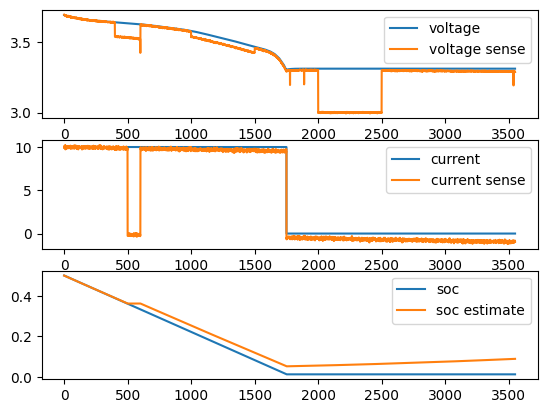

In [25]:
voltage_sensor = Sensor(
    name="voltage sensor",
    time=time,
    data=voltage,
    noise=Normal(0, 0.002),
    faults=[
        Offset(activation_probability=0.001, random_seed=2345, offset=-0.1),
        Offset(start_time=400, stop_time=600, offset=-0.1),
        Scaling(start_time=1000, stop_time=1500, scale=0.99),
        Drift(start_time=0, stop_time=np.inf, rate=-0.02 / 3600),
        StuckAt(start_time=2000, stop_time=2500, value=3.0),
    ],
)
current_sensor = Sensor(
    name="current sensor",
    time=time,
    data=current,
    noise=Normal(0, 0.1),
    faults=[
        StuckAt(start_time=500, stop_time=600, value=0.0),
        Drift(start_time=0, stop_time=np.inf, rate=-1 / 3600),
    ],
)
cc = CoulombCount(initial_soc=inputs.initial_soc, capacity=inputs.capacity, sampling_time=1.0)

v_sense = []
i_sense = []
soc_est = []
try:
    while True:
        voltage_reading = voltage_sensor.read()
        current_reading = current_sensor.read()

        soc_cc = cc.update(current_reading)

        v_sense.append(voltage_reading)
        i_sense.append(current_reading)
        soc_est.append(soc_cc)
except IndexError as e:
    print(e)


plt.figure()
plt.subplot(3, 1, 1)
plt.plot(time, voltage, label="voltage")
plt.plot(time, v_sense, label="voltage sense")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(time, current, label="current")
plt.plot(time, i_sense, label="current sense")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(time, soc, label="soc")
plt.plot(time, soc_est, label="soc estimate")
plt.legend()
plt.show()